In [2]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

import matplotlib.pyplot as plt

import os 

import numpy as np

os.chdir('/home/jlm217/rds/rds-mrc-bsu-csoP2nj6Y6Y/mimah/stopah/lili')

from treedata import *

import missingno as msno

### Missing-in-Attributes (MIA) approach 

The following is based on the CART split 

We will try the Missing-in-Attributes (MIA) approach 

Code missing as a separate category.


In [3]:
#Make all those values NA 

for x in stopah.columns:
    if len(stopah[stopah[x] == -2147483648].index) >0:
        #print(x)
        #print(stopah[stopah[x] == -2147483648].index)
        stopah[x][stopah[x] ==-2147483648] = np.nan
        
#stopah['Max.grams.of.alcohol.drunk.per.day..calc.'].loc[ [64, 164, 217, 220, 341, 351, 355, 507, 525, 538, 556, 599, 687, 693,
  #     723, 839, 933, 964, 986, 987, 991]]

/tmp/ipykernel_846650/2746276861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stopah[x][stopah[x] ==-2147483648] = np.nan
/tmp/ipykernel_846650/2746276861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stopah[x][stopah[x] ==-2147483648] = np.nan
/tmp/ipykernel_846650/2746276861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stopah[x][stopah[x] ==-2147483648] = np.nan
/tmp/ipykernel_846650/2746276861.py:7: SettingWithCo

In [4]:
stopah = stopah.drop(['D90_DTH'],axis=1) #Look at 28 day only 

old_col = list(stopah.columns)

In [5]:
mis_cat = []

categorical = ['D28_DTH','Prednisolone','Gender','Baseline_sepsis',
               'Baseline_GIB','PNPLA3_Rec','PNPLA3_Add','Hepatic.Encephalopathy...Merged']

for cat in categorical:
    print(cat +' : '+ str(stopah[cat].isna().sum()))
    if stopah[cat].isna().sum() > 0:
        mis_cat.append(cat)
        
#mis_cat

D28_DTH : 0
Prednisolone : 0
Gender : 0
Baseline_sepsis : 0
Baseline_GIB : 0
PNPLA3_Rec : 224
PNPLA3_Add : 224
Hepatic.Encephalopathy...Merged : 48


In [6]:
missing_cat1 = list(stopah[stopah['PNPLA3_Rec'].isna() == True].index)

In [7]:
stopah['PNPLA3_Rec_MIA'] = stopah['PNPLA3_Rec'].apply(lambda x: x==1 if x ==np.nan else 0)

stopah['PNPLA3_Add_MIA'] = stopah['PNPLA3_Add'].apply(lambda x: x==1 if x ==np.nan else 0)

In [8]:
stopah.drop(['PNPLA3_Add'], axis=1, inplace=True)

In [9]:
stopah['PNPLA3_Rec'].fillna(0,inplace=True)

In [10]:
#numerical variables 

missings = []

for x in stopah.columns:
    if (stopah[x].isna().sum())/len(stopah) > 0.0:
        missings.append(x)    

for mia in missings:
    mia_col1= mia + '1'
    mia_col2= mia + '2'
    
    stopah[mia_col1] =stopah[mia].fillna(-2147483648)
    stopah[mia_col2] =stopah[mia].fillna(2147483648)
    

In [11]:
#not sure about 'PNPLA3_Add', 'PNPLA3_Rec', HPCT_NG, Hepatic.Encephalopathy...Merged

#categoricals and targets 

excluded = ['D28_DTH','D90_DTH','Prednisolone', 'Hepatic.Encephalopathy...Merged',
                                            'Baseline_sepsis','Baseline_GIB','Gender', 'HPCT_NG',
                                            'PNPLA3_Add', 'PNPLA3_Rec']

In [12]:
stopah.drop(missings, axis=1, inplace=True) #same for 'bDNA'

In [13]:
#Split into train-test based on treatment 

train = stopah.loc[stopah['Prednisolone']==0].drop(['Prednisolone'], axis=1)

test= stopah.loc[stopah['Prednisolone']==1].drop(['Prednisolone'], axis=1)

train.reset_index()
test.reset_index()

index  D28_DTH  Gender  Baseline_sepsis  Baseline_GIB  \
0        1        0       0                0             0   
1        4        0       0                0             0   
2        5        0       0                0             0   
3       11        0       0                0             0   
4       13        0       0                0             0   
..     ...      ...     ...              ...           ...   
529   1060        0       1                0             0   
530   1061        0       0                1             0   
531   1062        0       0                0             0   
532   1065        0       1                0             0   
533   1066        0       0                1             0   

     Age.at.randomisation..calc.  PNPLA3_Rec  Gender_2  Baseline_sepsis_2  \
0                           67.9         0.0         1                  1   
1                           37.6         1.0         1                  1   
2                           50.1         0.0         1                  1   
3                           53.7         0.0         1                  1   
4                           35.8         0.0         1                  1   
..                           ...         ...       ...                ...   
529                         27.8         0.0         0                  1   
530                         56.4         0.0         1                  0   
531                         66.4         0.0         1                  1   
532                         50.5         0.0         0                  1   
533                         63.5         0.0         1                  0   

     Baseline_GIB_2  PNPLA3_Rec_2  Hepatic.Encephalopathy...Merged_0  \
0                 1             1                                  0   
1                 1             0                                  1   
2                 1             1                                  1   
3                 1             1                                  1   
4                 1             1                                  1   
..              ...           ...                                ...   
529               1             1                                  1   
530               1             1                                  1   
531               1             0                                  1   
532               1             1                                  1   
533               1             1                                  1   

     Hepatic.Encephalopathy...Merged_1  Hepatic.Encephalopathy...Merged_2  \
0                                    1                                  0   
1                                    0                                  0   
2                                    0                                  0   
3                                    0                                  0   
4                                    0                                  0   
..                                 ...                                ...   
529                                  0                                  0   
530                                  0                                  0   
531                                  0                                  0   
532                                  0                                  0   
533                                  0                                  0   

     PNPLA3_Add_0  PNPLA3_Add_1  PNPLA3_Add_2  PNPLA3_Rec_MIA  PNPLA3_Add_MIA  \
0               1             0             0               0               0   
1               0             0             1               0               0   
2               1             0             0               0               0   
3               0             1             0               0               0   
4               0             1             0               0               0   
..            ...           ...           ...             .

In [14]:
X_train = train.drop(['D28_DTH'],axis=1)
y_train = train['D28_DTH']

X_test = test.drop(['D28_DTH'],axis=1)
y_test = test['D28_DTH']


In [22]:
X_train.head()

Gender  Baseline_sepsis  Baseline_GIB  Age.at.randomisation..calc.  \
0       0                0             0                         61.7   
2       0                0             0                         49.9   
3       0                0             0                         47.1   
6       1                0             0                         40.5   
7       1                0             0                         47.2   

   PNPLA3_Rec  Gender_2  Baseline_sepsis_2  Baseline_GIB_2  PNPLA3_Rec_2  \
0         0.0         1                  1               1             1   
2         0.0         1                  1               1             1   
3         0.0         1                  1               1             1   
6         0.0         0                  1               1             1   
7         0.0         0                  1               1             1   

   Hepatic.Encephalopathy...Merged_0  Hepatic.Encephalopathy...Merged_1  \
0                                  0                                  0   
2                                  1                                  0   
3                                  0                                  0   
6                                  1                                  0   
7                                  1                                  0   

   Hepatic.Encephalopathy...Merged_2  PNPLA3_Add_0  PNPLA3_Add_1  \
0                                  1             1             0   
2                                  0             1             0   
3                                  0             0             1   
6                                  0             1             0   
7                                  0             0             1   

   PNPLA3_Add_2  PNPLA3_Rec_MIA  PNPLA3_Add_MIA       Weight1       Weight2  \
0             0               0               0 -2.147484e+09  2.147484e+09   
2             0               0               0  7.000000e+01  7.000000e+01   
3             0               0               0  8.400000e+01  8.400000e+01   
6             0               0               0  7.500000e+01  7.500000e+01   
7             0               0               0  4.250000e+01  4.250000e+01   

   Max.grams.of.alcohol.drunk.per.day..calc.1  \
0                                        96.0   
2                                       246.0   
3                                       371.0   
6                                       320.0   
7                                        61.0   

   Max.grams.of.alcohol.drunk.per.day..calc.2  \
0                                        96.0   
2                                       246.0   
3                                       371.0   
6                                       320.0   
7                                        61.0   

   Hepatic.Encephalopathy...Merged1  Hepatic.Encephalopathy...Merged2  \
0                      2.000000e+00                      2.000000e+00   
2                      0.000000e+00                      0.000000e+00   
3                     -2.147484e+09                      2.147484e+09   
6                      0.000000e+00                      0.000000e+00   
7                      0.000000e+00                      0.000000e+00   

   Temperature...Merged1  Temperature...Merged2  Pulse...Merged1  \
0                   37.8                   37.8             85.0   
2                   37.4                   37.4            111.0   
3                   36.8                   36.8             86.0   
6                   37.5                   37.5             94.0   
7                   36.5                   36.5             95.0   

   Pulse...Merged2  Systolic.BP...Merged1  Systolic.BP...Merged2  \
0             85.0                  135.0                  135.0   
2            111.0                  100.0                  100.0   
3             86.0                  110.0                  110.0   
6             94.0                  102.0                  102

In [14]:
#Balance weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)


rf = RandomForestClassifier(n_estimators=15,max_depth=8,random_state=24,criterion='gini',min_samples_split=10)

In [15]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=10, n_estimators=15,
                       random_state=24)

In [16]:
pred_prob = rf.predict_proba(X_test)

auc_score = roc_auc_score(y_test, pred_prob[:,1])

print('Training accuracy: ', np.mean(rf.predict(X_train) ==y_train)*100) 
print ('Test accuracy:', np.mean(rf.predict(X_test) ==y_test)*100)
print('AUC Score:',(auc_score)*100)

Training accuracy:  92.32209737827716
Test accuracy: 85.2059925093633
AUC Score: 75.66013071895425


In [17]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

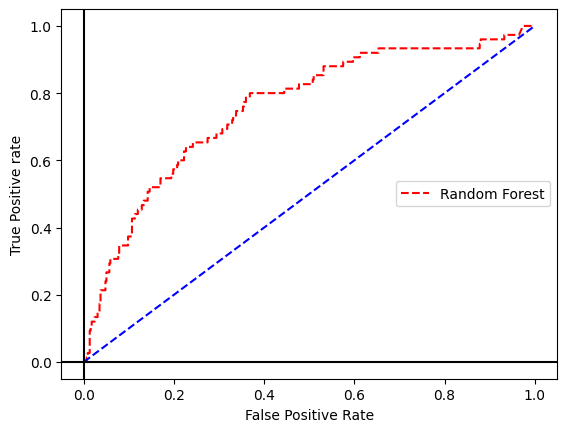

In [18]:
plt.axes(facecolor='white')
# plot roc curves

plt.plot(fpr, tpr, linestyle='--',color='red',label='Random Forest') #label='Random Forest'
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

#plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.grid(False)

plt.axhline(0, color='black')
plt.axvline(0, color='black')

#ax = fig.add_axes([1,1,0,0])

#ax.set_facecolor("white")

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

